# Peer Project - Image Classification with CNN

Idea behind this project is to use gdown for downloading image dataset to train our CNN model and from random url, fetch an image and predicting the category of that image, fetch similar images from our dress.cv datasets


# Importing necessary libraries

In [3]:
import numpy as np 
import pandas as pd 

from matplotlib import pyplot as plt
%matplotlib inline 


import urllib #For fetching data from Web URLs

import cv2   #For image processing

from sklearn.preprocessing import LabelEncoder   
from sklearn.model_selection import train_test_split 
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

#Directory

In [5]:
import os
for dirname,_, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


data/.DS_Store
data/dress.csv
data/model.hdf5
data/X.npy


# general dataset taken from kaggle for some function analysis purpose

In [6]:
#Import the dataset

df = pd.read_csv(r'data/dress.csv')
df.head()

,_unit_id,category,category:confidence,image_url
0,851505458,ikat,0.3487,http://s3-eu-west-1.amazonaws.com/we-attribute...
1,851505459,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
2,851505460,polka dot,0.6709,http://s3-eu-west-1.amazonaws.com/we-attribute...
3,851505461,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
4,851505462,geometry,0.7035,http://s3-eu-west-1.amazonaws.com/we-attribute...


In [7]:
def fetching_image(image_url):

  """
  Fetching images from image_url and plotting it using matplotlib to show some function analysis
  """

  url = urllib.request.urlopen(image_url)
  image = np.array(bytearray(url.read()), dtype = 'uint8')
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

  plt.imshow(image_rgb)
  plt.axis('off');


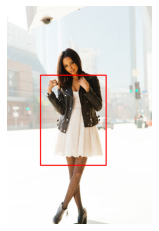

In [8]:
fetching_image(df['image_url'].loc[300])

we will use these above function later in our notebook while processing the image

In [9]:
df.shape

(15702, 4)

In [10]:
print('All categories : \n ', df['category'].unique())

All categories : 
  ['ikat' 'plain' 'polka dot' 'geometry' 'floral' 'squares' 'scales'
 'animal' 'OTHER' 'stripes' 'tribal' 'houndstooth' 'cartoon' 'chevron'
 'stars' 'letter_numb' 'skull']


In [11]:
n_classes = df['category'].nunique()
print('Total number of unique categories:', n_classes)

Total number of unique categories: 17


In [12]:
df = df.loc[(df['category'] != 'OTHER')].reset_index(drop=True)

In [13]:
df['category'].nunique()


16

Well, as we can notice, we have 15702 image_url which will take lot of time to fetch in as a image dataset
so rather, we will use gdown to download a set of images and use that to train our model and performing 
other operations

But if we want, we can use the following function and iterating each image_url to this function and appending it to the list 

In [14]:
def image_processing(image_url):

  """
  Converts the URL of any image to an array of size 100x1 
  The array represents an OpenCV grayscale version of the original image
  The image will get cropped along the biggest red contour (4 line polygon) tagged on the original image (if any)
  """

  #Download from image url and import it as a numpy array
  response = urllib.request.urlopen(image_url)
  image = np.asarray(bytearray(response.read()), dtype="uint8")                         

  #Read the numpy arrays as color images in OpenCV
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)

    #Convert to HSV for creating a mask
  image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

  #Convert to grayscale that will actually be used for training, instead of color image 
  image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

  #Create a mask that detects the red rectangular tags present in each image
  mask = cv2.inRange(image_hsv, (0,255,255), (0,255,255))

  #Get the coordinates of the red rectangle in the image, 
  #But take entire image if mask fails to detect the red rectangle
  if len(np.where(mask != 0)[0]) != 0:
    y1 = min(np.where(mask != 0)[0])
    y2 = max(np.where(mask != 0)[0])
  else:
    y1 = 0                                     
    y2 = len(mask)
  
  if len(np.where(mask != 0)[1]) != 0:
    x1 = min(np.where(mask != 0)[1])
    x2 = max(np.where(mask != 0)[1])
  else:
    x1 = 0
    x2 = len(mask[0])
    
    #Crop the grayscle image along those coordinates
  image_cropped = image_gray[y1:y2, x1:x2]

  #Resize the image to 100x100 pixels size
  image_100x100 = cv2.resize(image_cropped, (100, 100))

  #Save image as in form of array of 10000x1
  image_arr = image_100x100.flatten()
  return image_arr

In [15]:
"""
image_list = []

for url in df['image_url'] :
  image_list.append(image_processing(url))

X = np.array(image_list)

X = X/255

X = np.save('data/X.npy', X)
"""

"\nimage_list = []\n\nfor url in df['image_url'] :\n  image_list.append(image_processing(url))\n\nX = np.array(image_list)\n\nX = X/255\n\nX = np.save('data/X.npy', X)\n"

# Using gdown to download the image dataset for our model 

In [16]:
#pip install gdown

In [17]:
# import gdown

# url = 'https://drive.google.com/uc?id=1B6_rtcmGRy49hqpwoJT-_Ujnt6cYj5Ba'
# output = 'X.npy'
# gdown.download(url, output, quiet=False)

In [18]:
X = np.load('data/X.npy')

X.shape

(15189, 10000)

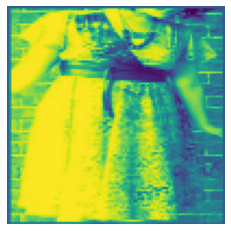

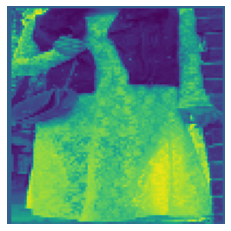

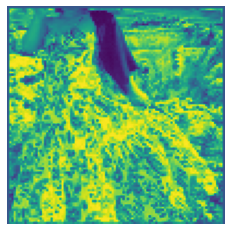

In [19]:
#Pick 3 processed photos from 'X' at random and plot them.
np.random.seed(2)
for i in np.random.randint(0, len(X),3):
    plt.figure()
    plt.imshow(X[i].reshape(100,100))
    plt.axis('off')

In [20]:
#Transforming our categorical columns from our kaggle dataset into numerical labels

encoder = LabelEncoder()
encoded_y = encoder.fit_transform(df['category'])
np.unique(encoded_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [21]:
#finally we will perform on-hot encoding to get vector form of our labelled categories

y = to_categorical(encoded_y, num_classes = n_classes)
y[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

# splitting data for train and validation set

In [22]:
#test set
X_test = X[14000:,]
y_test = y[14000:,]

#Distinguishing a validation set from the rest of the training set (required for validation while training)

X_train, X_val, y_train, y_val = train_test_split(X[:14000,], y[:14000,], test_size=0.15, random_state=42)


In [23]:
#Reshaping the shape of train and test and validation datasets

img_rows = 100
img_cols = 100

input_shape = (img_rows, img_cols , 1)
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_train.shape


(11900, 100, 100, 1)

# Building Convolutional Neural Network Model

In [24]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3) , activation = 'relu',
                input_shape =input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(n_classes, activation = 'softmax'))

learning_rate = 0.001
opt = tensorflow.keras.optimizers.RMSprop(lr = learning_rate, decay = 1e-6)
model.compile(loss= categorical_crossentropy,
             optimizer = Adam(learning_rate),
             metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        4

/Users/khushi/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [25]:
#Save the model

save_at = "data/model.hdf5"
saved_model = ModelCheckpoint(save_at, monitor = 'val_accuracy', verbose = 0, save_best_only = True, save_weights_only = False, mode = 'max')

# Training our model 

2022-04-20 23:20:23.376101: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
119/119 [==============================] - 118s 974ms/step - loss: 1.9419 - accuracy: 0.6003 - val_loss: 2.4215 - val_accuracy: 0.1690
Epoch 2/15
119/119 [==============================] - 210s 2s/step - loss: 1.3571 - accuracy: 0.6583 - val_loss: 3.5060 - val_accuracy: 0.2076
Epoch 3/15
119/119 [==============================] - 116s 977ms/step - loss: 1.2849 - accuracy: 0.6734 - val_loss: 1.4561 - val_accuracy: 0.6000
Epoch 4/15
119/119 [==============================] - 118s 992ms/step - loss: 1.2380 - accuracy: 0.6823 - val_loss: 1.3217 - val_accuracy: 0.6662
Epoch 5/15
119/119 [==============================] - 125s 1s/step - loss: 1.1773 - accuracy: 0.6908 - val_loss: 1.2125 - val_accuracy: 0.6867
Epoch 6/15
119/119 [==============================] - 129s 1s/step - loss: 1.1441 - accuracy: 0.6977 - val_loss: 1.1587 - val_accuracy: 0.6952
Epoch 7/15
119/119 [==============================] - 130s 1s/step - loss: 1.1141 - accuracy: 0.7055 - val_loss: 1.1783 - val_accurac

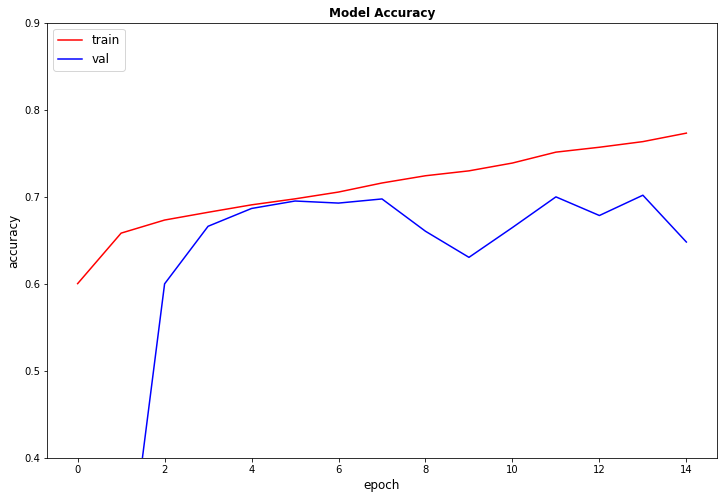

In [23]:
history = model.fit(X_train, y_train, 
                   epochs = 15, batch_size = 100,
                   callbacks = [saved_model], verbose = 1,
                   validation_data = (X_val, y_val),
                   shuffle = True)

#Plotting the acurracies (train and validation data)

plt.figure(figsize = (12,8))
plt.plot(history.history['accuracy'] , color = 'r')
plt.plot(history.history['val_accuracy'], color = 'b')
plt.title('Model Accuracy', weight = 'bold', fontsize = 12)
plt.xlabel ('epoch', fontsize = 12)
plt.ylabel ('accuracy', fontsize = 12)
plt.ylim(0.4, 0.9)
plt.legend(['train', 'val'], loc = 'upper left', prop = {'size': 12})
plt.show()


In [26]:
#Evaluating our test set

model = load_model('data/model.hdf5')
acc_score = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy over the test set: \n" , round((acc_score[1]*100),2), '%')


2022-04-29 21:10:33.890070: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Accuracy over the test set: 
 70.56 %


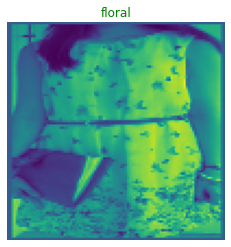

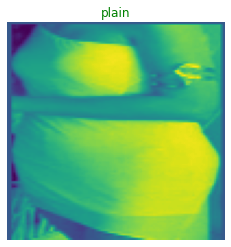

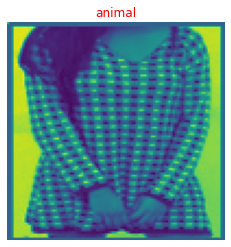

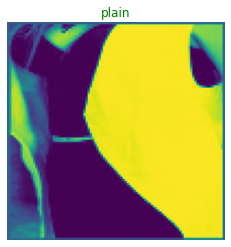

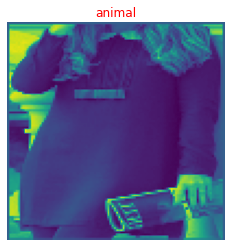

In [35]:
y_pred = np.round(model.predict(X_test))

np.random.seed(23)
for rand_num in np.random.randint(0, len(y_test), 5):
  plt.figure()
  plt.imshow(X_test[rand_num].reshape(100, 100)), plt.axis('off')
  if np.where(y_pred[rand_num] == 1)[0].sum() == np.where(y_test[rand_num] == 1)[0].sum():
    plt.title(encoder.classes_[np.where(y_pred[rand_num] == 1)[0].sum()], color='g')
  else :
    plt.title(encoder.classes_[np.where(y_pred[rand_num] == 1)[0].sum()], color='r')

In [27]:
def likewise_images(image_url, no_of_images):
    
    """
    It takes an image url and the number of comparable photos that are required.
    In the image, the model gives a prediction about the clothing category.
    The original image is displayed with the required number of comparable photos from the collection.
    """
    
    X_original = image_processing(image_url)
    X_original = X_original / 255
    X_original = X_original.reshape(1,100,100,1)
    y_predict = np.round(model.predict(X_original))
    i = np.where(y_predict ==1)[0].sum()
    print("category detected by model:" , encoder.classes_[i].upper())
    df_req = df.loc[df['category'] == encoder.classes_[i]]
    df_req = df_req.reset_index(drop = True)
    
    if no_of_images > len(df_req):
        return (print ('number of images required are more than similar images in dataset'))
    plt.figure()
    fetching_image(image_url)
    plt.title('Original Image')
    
    c=1
    np.random.seed(13)
    for j in np.random.randint(0, len(df_req), no_of_images):
        plt.figure()
        url = df_req['image_url'].iloc[j]
        fetching_image(url)
        plt.title('Likewise Image {}'. format (c))
        c += 1

category detected by model: ANIMAL


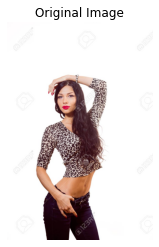

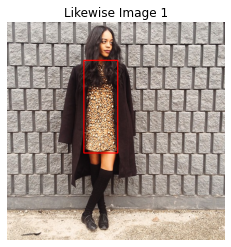

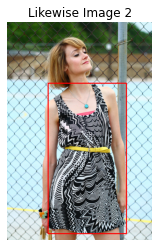

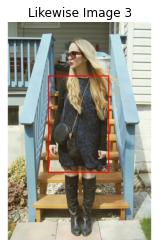

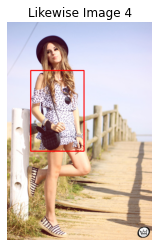

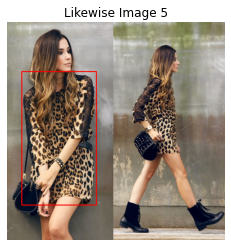

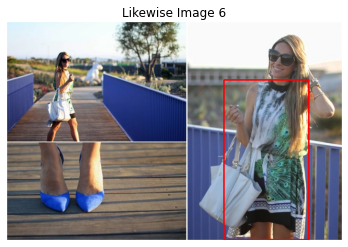

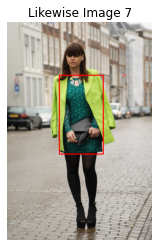

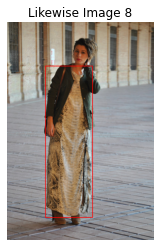

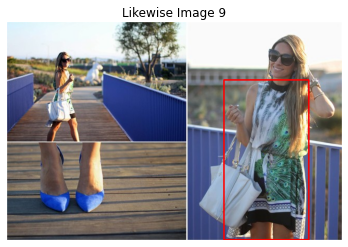

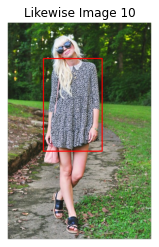

In [29]:
likewise_images('https://previews.123rf.com/images/gorosi/gorosi1509/gorosi150900145/45171143-%E5%8B%95%E7%89%A9%E3%83%97%E3%83%AA%E3%83%B3%E3%83%88-%E3%83%88%E3%83%83%E3%83%97%E3%81%A8%E3%82%B8%E3%83%BC%E3%83%B3%E3%82%BA%E3%81%A7%E3%82%B9%E3%83%AA%E3%83%A0%E3%81%AA%E7%BE%8E%E3%81%97%E3%81%84%E5%A5%B3%E3%81%AE%E5%AD%90%E3%81%AE%E5%86%99%E7%9C%9F%E3%80%82%E8%A3%B8%E3%81%AE%E8%85%B9%E7%99%BD%E3%81%AE%E3%81%8D%E3%82%8C%E3%81%84%E3%81%AA%E5%A5%B3%E6%80%A7%E3%81%AF%E3%80%81%E8%83%8C%E6%99%AF%E3%82%92%E5%88%86%E9%9B%A2%E3%81%97%E3%81%BE%E3%81%97%E3%81%9F%E3%80%82.jpg?fj=1', 10)

# Conclusion

As one can see, how we took our gdown data and did necessary feature engineering and passed through function to predict the similar images from our dataset which consist of amazon url links


# Next Step

we can do some more epochs and try different learning rate as well as experiment with some other loss function like RMSprop inorder to increase the efficiency of our model.

Though the process is extremly time consuming as it involves lots of computation because of big dataset. But doing above things and finding optimal balance between the tradeoff will increase the efficiency of model.
